In [3]:
%reload_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import kmapper as km
from cereeberus import Interleave, ReebGraph, MapperGraph, Assignment
import kmapper as km
from sklearn.cluster import DBSCAN
from sklearn import datasets
import networkx as nx

import letters  # this generates letter data. Right now I am generating A, B, D, I, R, M
import process_letters as pl # this creates the mapper graph from the letter data

In [ ]:
def plot_mapper(mapper, sample):

    #plot the mapper and the sample side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].set_title("Mapper Graph")
    mapper.draw(ax=axes[0])
    axes[1].set_title("Sample Points")
    axes[1].scatter(sample[:, 0], sample[:, 1], s=1)
    axes[1].set_xlim(-1, 1)
    axes[1].set_ylim(-1, 2)
    axes[1].set_aspect('equal')
    plt.tight_layout()
    plt.show()

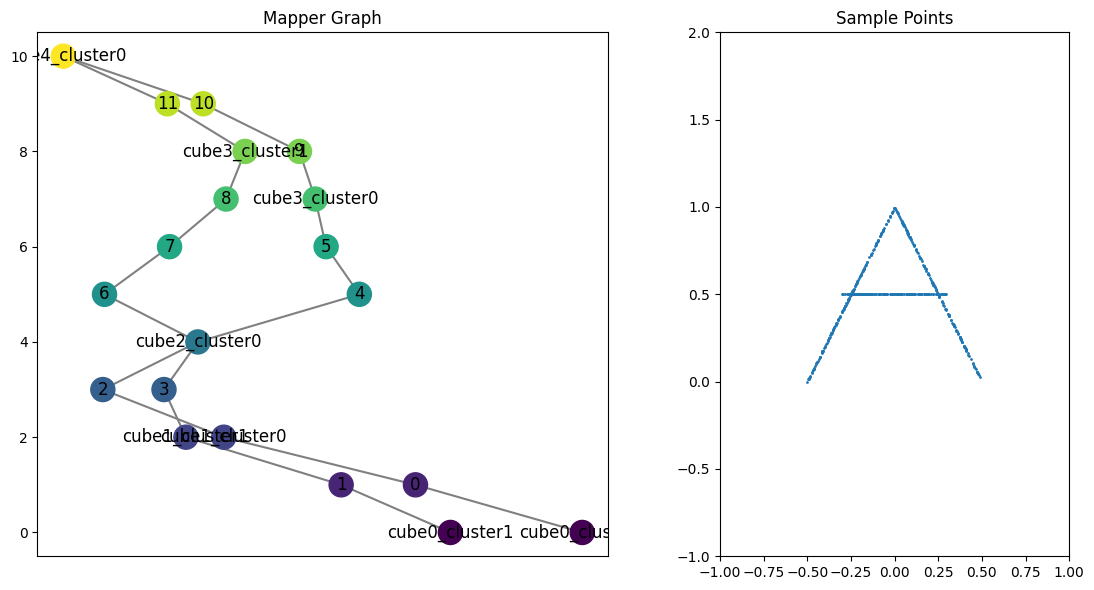

In [13]:
mapper = pl.generate_mapper(letter_data['A'][0])
plot_mapper(mapper, letter_data['A'][0])

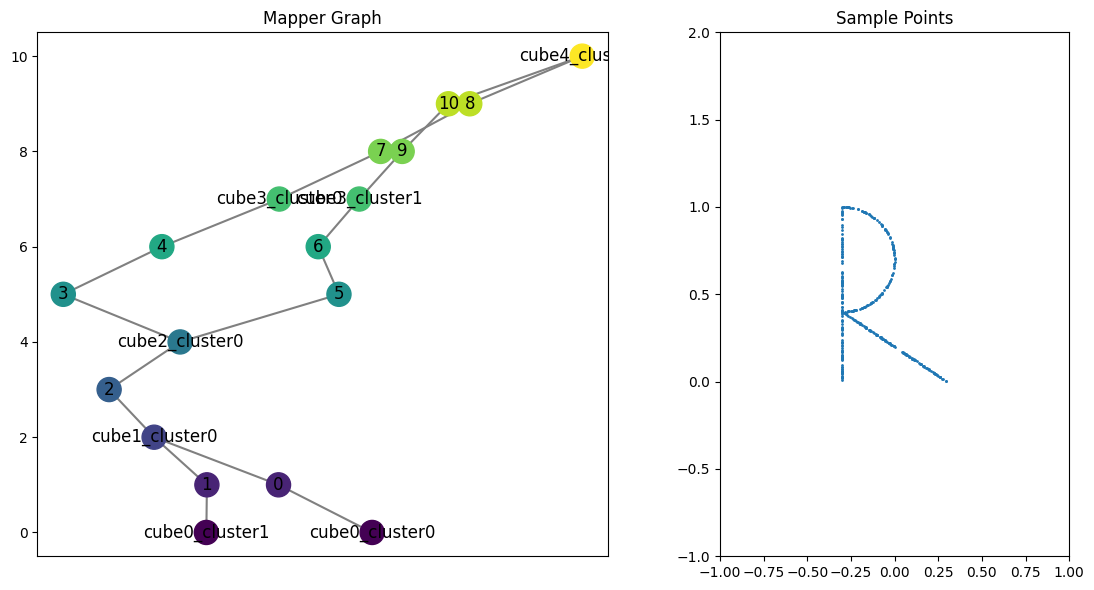

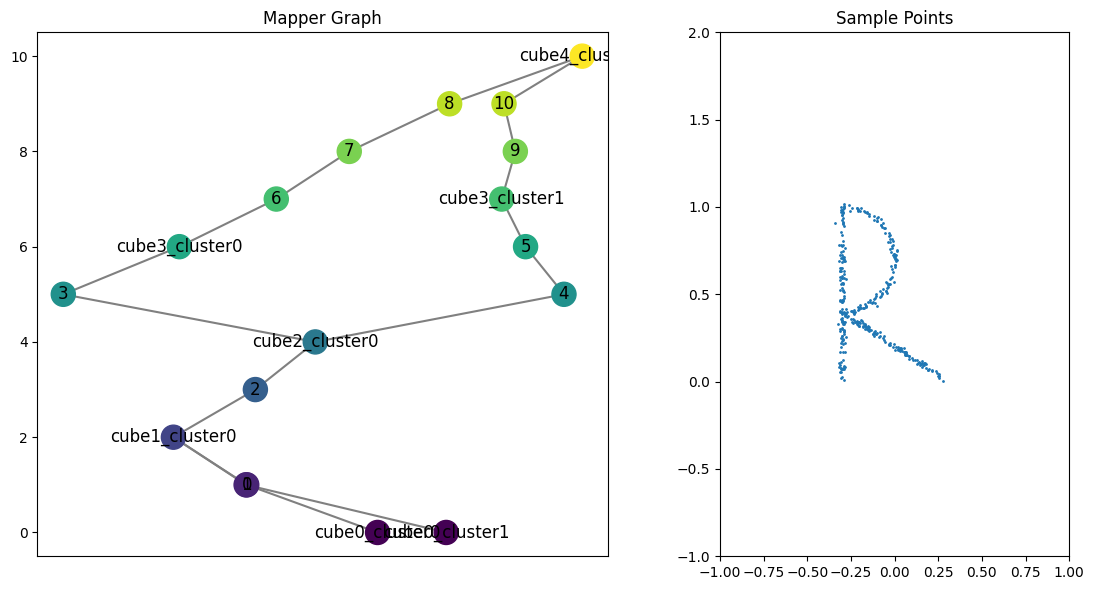

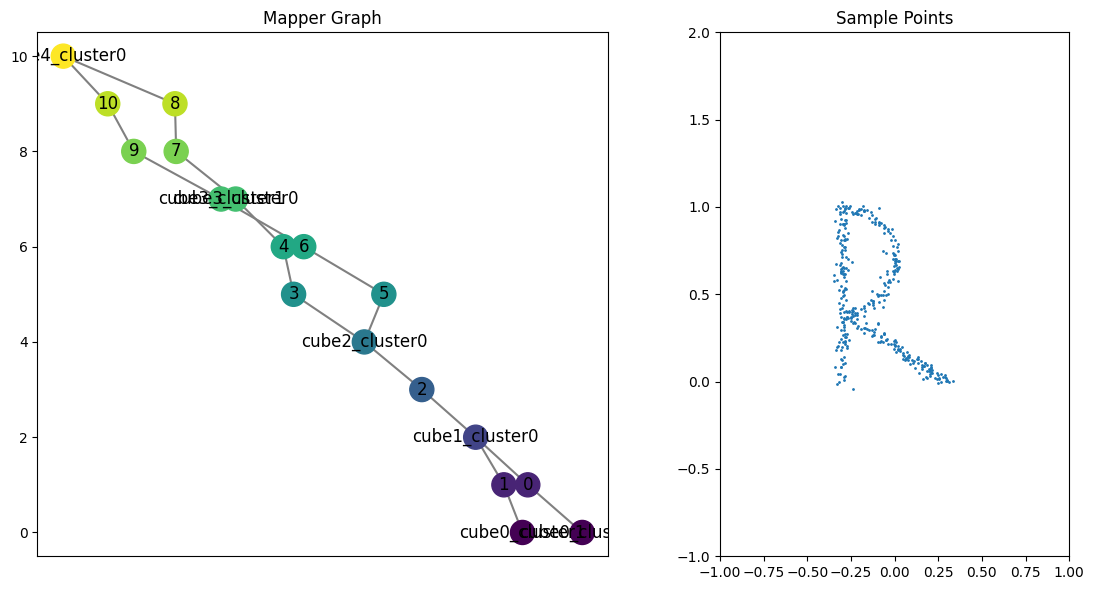

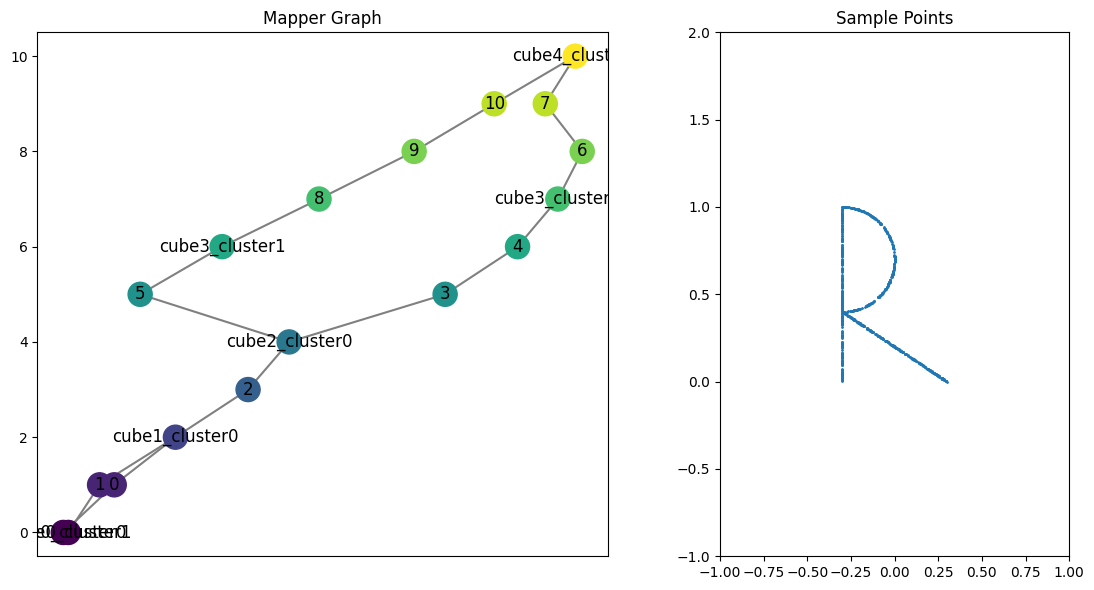

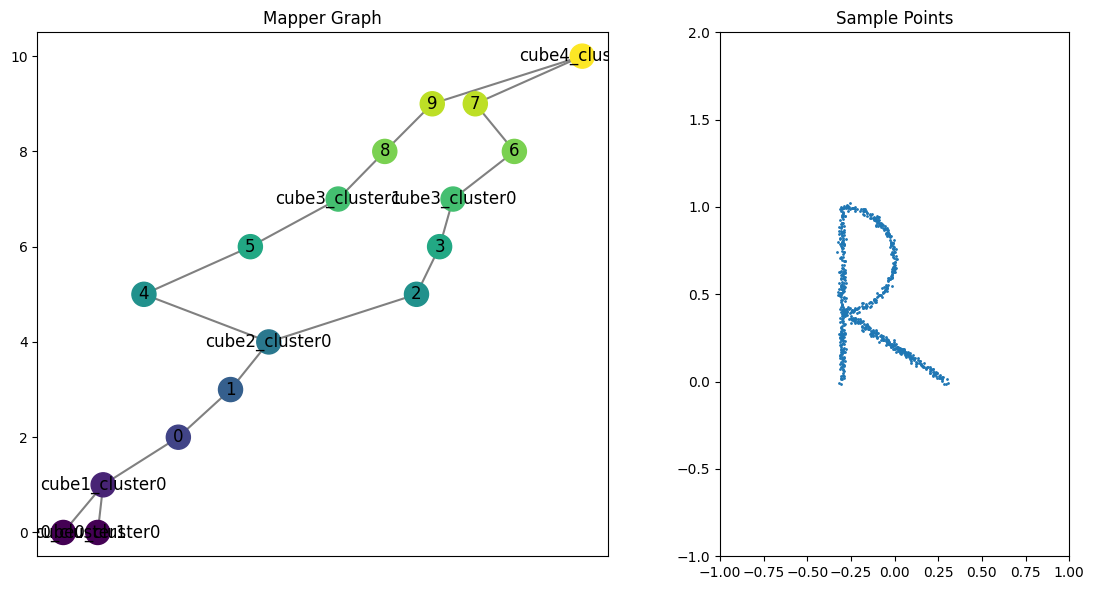

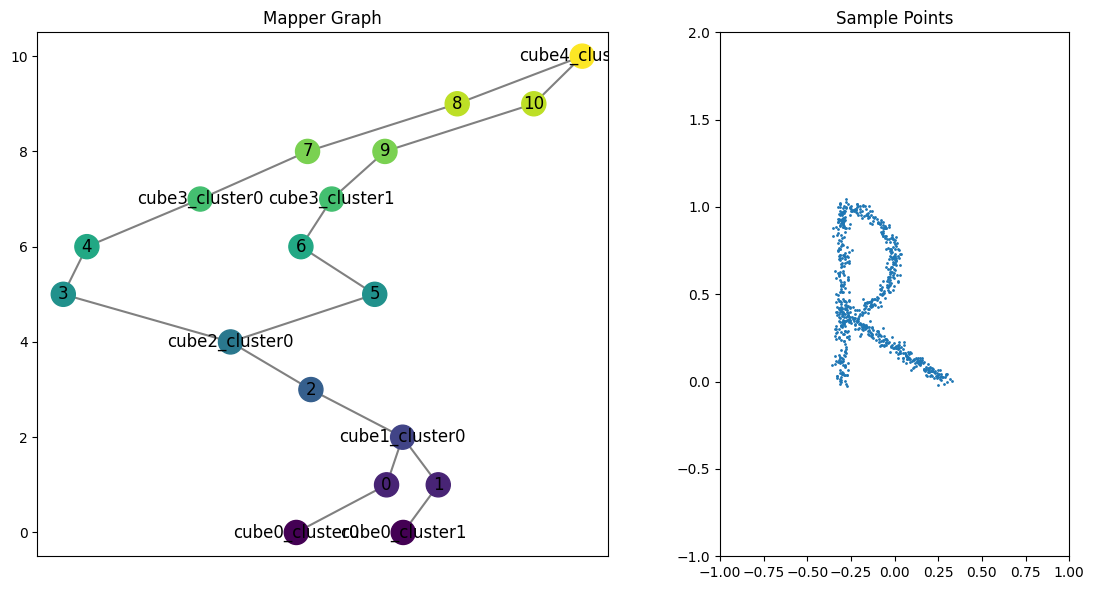

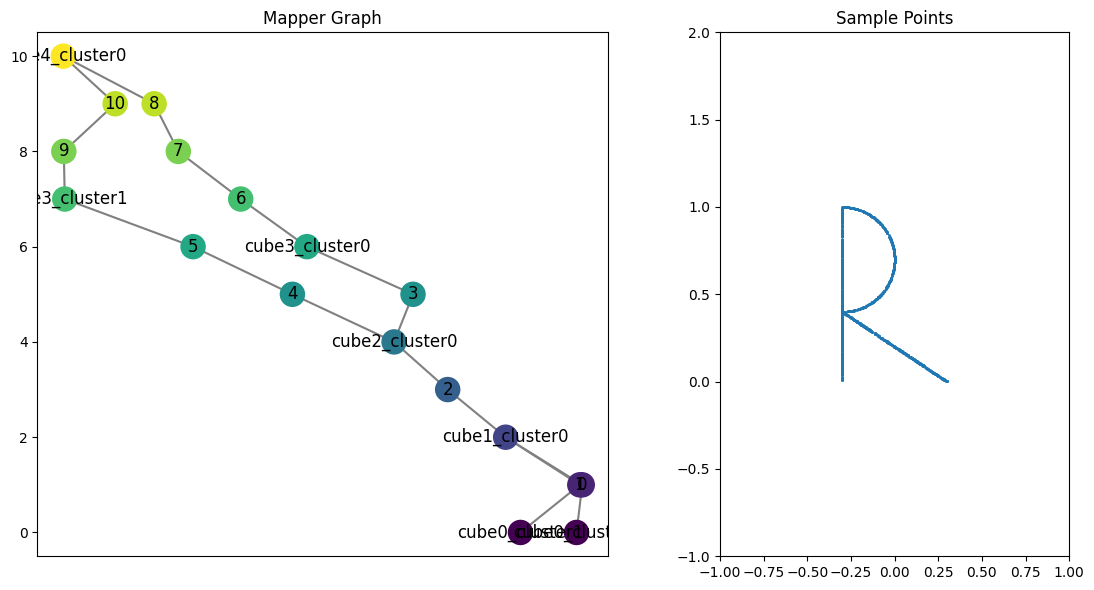

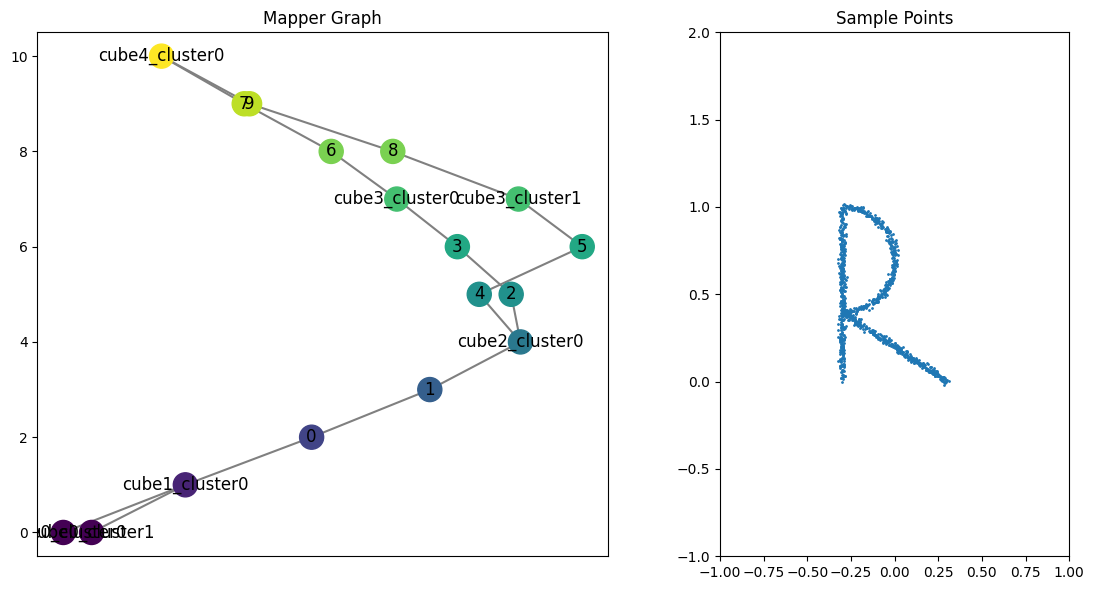

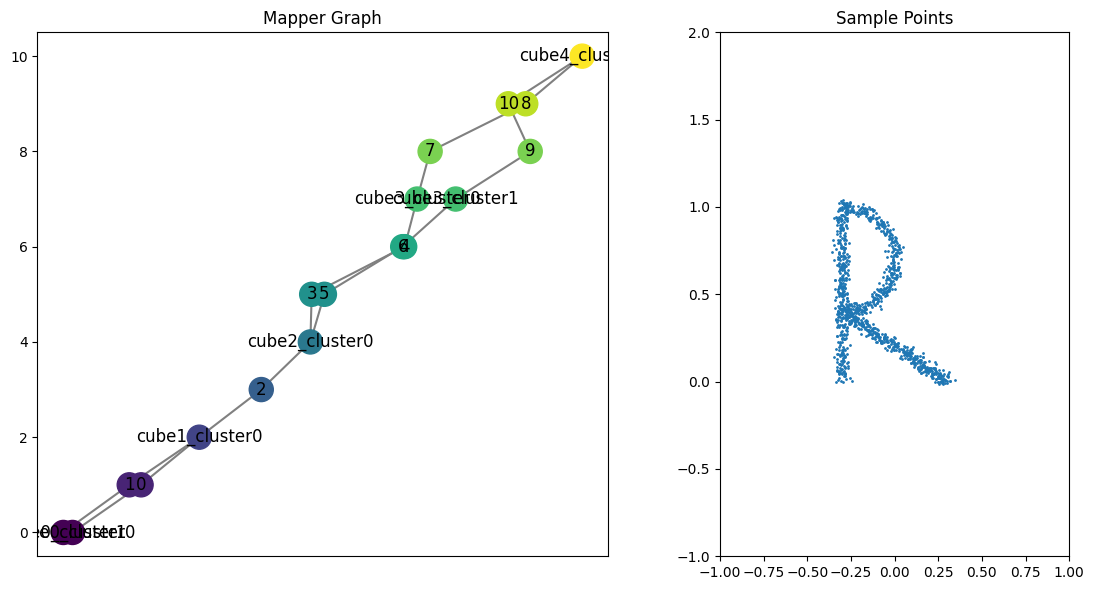

In [21]:
for i in letter_data['R']:
    mapper = pl.generate_mapper(i)
    plot_mapper(mapper, i)
    # get the min and max height of the mapper graph
    min_height = min(mapper.get_function_values())
    max_height = max(mapper.get_function_values())

    

## Create the Mappers from the letter data 

In [10]:
letter_data = letters.gen_letters()

In [11]:
keys = list(letter_data.keys())

# Create mappers for all letters
mappers = {}
for key in keys:
    mappers[key] = []
    for sample in letter_data[key]:
        mapper = pl.generate_mapper(sample)
        mappers[key].append(mapper)

## Test the workflow

In [ ]:
from cereeberus import Interleave
import itertools
from multiprocessing import Pool, cpu_count
import letters, process_letters
from tqdm import tqdm
import pandas as pd


def get_input_data():
    letter_data = letters.gen_letters() # these are point clouds
      
    mappers = {}
    for key, samples in letter_data.items():
        mappers[key] = [process_letters.generate_mapper(sample) for sample in samples]
    return mappers

def pairwise_comparison(args):
    letter1, idx1, letter2, idx2, mappers = args
    
    mapper1 = mappers[letter1][idx1]
    mapper2 = mappers[letter2][idx2]

    myInt = Interleave(mapper1, mapper2)
    val = myInt.fit()

    return (f"{letter1}_{idx1}", f"{letter2}_{idx2}", val)

def run_all_comparisons(mappers, num_procs = None):
    if num_procs is None:
        num_procs = cpu_count()

    letters = sorted(mappers.keys())

    tasks = []

    for l1, l2 in itertools.combinations_with_replacement(letters, 2):
        for i, j in itertools.product(range(len(mappers[l1])), range(len(mappers[l2]))):
            tasks.append((l1, i, l2, j, mappers))

    results = []

    with Pool(processes=num_procs) as pool:
        for res in tqdm(pool.imap(pairwise_comparison, tasks), total=len(tasks)):
            results.append(res)

    df = pd.DataFrame(results, columns=["Mapper1", "Mapper2", "Upper Bound"])
    return df

In [17]:


mappers = get_input_data()
df = run_all_comparisons(mappers, num_procs=32)
df.to_csv("pairwise_results.csv", index=False)

100%|██████████| 1701/1701 [05:41<00:00,  4.98it/s]


In [18]:
df.head()

,Mapper1,Mapper2,Upper Bound
0,A_0,A_0,0
1,A_0,A_1,1
2,A_0,A_2,0
3,A_0,A_3,0
4,A_0,A_4,0


## Store the as a table and do analysis

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
all_names = sorted(set(df['Mapper1']).union(set(df['Mapper2'])))

table = pd.DataFrame(0, index=all_names, columns=all_names, dtype=int)

for _, row in df.iterrows():
    table.at[row['Mapper1'], row['Mapper2']] = row['Upper Bound']
    table.at[row['Mapper2'], row['Mapper1']] = row['Upper Bound']

table.to_csv("pairwise_results_table.csv")



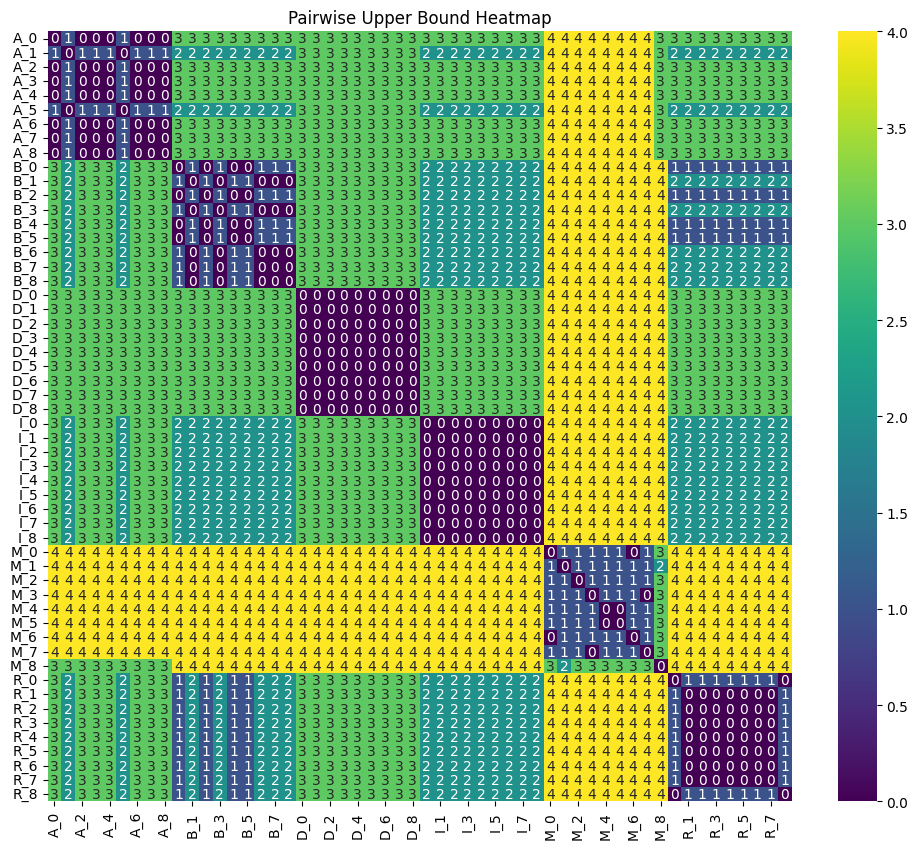

In [25]:
# show the table as a heatmap

plt.figure(figsize=(12, 10))
sns.heatmap(table.astype(float), cmap="viridis", annot=True)
plt.title("Pairwise Upper Bound Heatmap")
plt.show()

In [32]:
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS
import matplotlib.pyplot as plt


/mnt/home/ghoshis3/.conda/envs/interleavingenv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


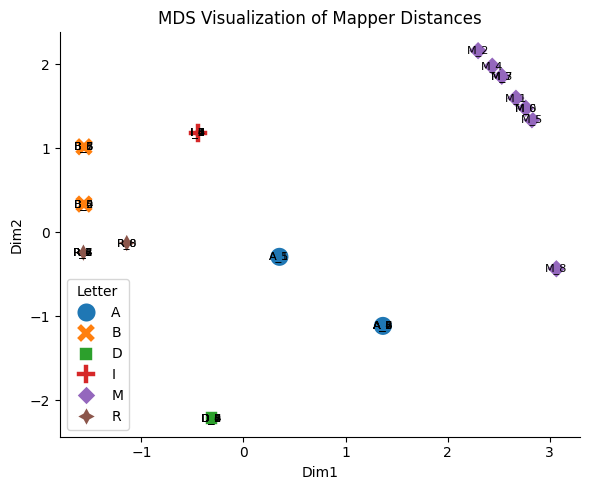

In [37]:

# Extract letters from mapper names for coloring
mapper_labels = [name.split("_")[0] for name in table.index]

# Prepare distance matrix
distance_matrix = table.values.astype(float)

# Run MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coords = mds.fit_transform(distance_matrix)

# Create DataFrame for plotting
mds_df = pd.DataFrame(coords, columns=["Dim1", "Dim2"])
mds_df["Letter"] = mapper_labels
mds_df["Mapper"] = table.index

# Plot with Seaborn
plt.figure(figsize=(6, 5))
sns.scatterplot(data=mds_df, x="Dim1", y="Dim2", hue="Letter", style="Letter", s=200, palette="tab10")

# Add labels
for i, row in mds_df.iterrows():
    plt.text(row["Dim1"], row["Dim2"], row["Mapper"], fontsize=8, ha="center", va="center")

plt.title("MDS Visualization of Mapper Distances")
# plt.xlabel("MDS Dimension 1")
# plt.ylabel("MDS Dimension 2")
plt.grid(False)
sns.despine()
plt.tight_layout()
plt.show()
